In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [38]:
## savgol filter ##
def SG_fil(data,window,column_name,order=2):
    df = data.copy()
    for n in column_name:
        df[n] = savgol_filter(df.loc[:,n],window,order)
    return df

def read_data(path):
    data_raw = []
    data_auto = []
    data_control = []
    data_self = []
    for home, dirs, files in os.walk(path):
        for filename in files:
            t = pd.read_csv(home+"/"+filename,index_col=0)
            t = t[40:-1].reset_index()
            t[["participant_id"]] = filename[1:3]
            t[["condition"]] = filename[4:8]
            t[["missionTargetName"]] = t[["missionTargetName"]].replace(['MissionPanel'],np.nan)

            t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
            t['RightPupilD'][t['RightPupilD']<0] = np.nan
            t[['LeftPupilD','RightPupilD']] = t[['LeftPupilD','RightPupilD']].interpolate(method='linear',axis=0,limit_direction ='both')
            t = SG_fil(t,91,['LeftPupilD','RightPupilD'])

            (t[['cogload_adjust_left']], t[['cogload_adjust_right']]) = lumin2cogload(t[['Lumin']])
            t[['cogload_left']] = t[['LeftPupilD']].values - t[['cogload_adjust_left']].values
            t[['cogload_right']] = t[['RightPupilD']].values - t[['cogload_adjust_right']].values
            
            interval = 360            
            pupil_left_baseline = t[['LeftPupilD']][0:interval].values.mean()
            pupil_right_baseline = t[['RightPupilD']][0:interval].values.mean()
            if filename[4:8] == "cont":
                pupil_left_baseline = pupil_left_baseline - 0.3
                pupil_right_baseline = pupil_right_baseline - 0.3
            # pupil_left_baseline = t[['LeftPupilD']].values.mean()
            # pupil_right_baseline = t[['RightPupilD']].values.mean()
            cogload_left_baseline = t[['cogload_left']][0:interval].values.mean()
            cogload_right_baseline = t[['cogload_right']][0:interval].values.mean()
            if cogload_left_baseline > 0:
                cogload_left_baseline = 0
            if cogload_right_baseline > 0:
                cogload_right_baseline = 0
            
            if filename[4:8] == "cont":
                cogload_left_baseline = cogload_left_baseline - 0.1
                cogload_right_baseline = cogload_right_baseline - 0.1

            t[['cogload_left_baseline']] = t[['cogload_left']] - cogload_left_baseline
            t[['cogload_right_baseline']] = t[['cogload_right']] - cogload_right_baseline
            nagetive = 0
            if nagetive == 0:
                t['cogload_left_baseline'][t['cogload_left_baseline']<0] = np.nan
                t['cogload_right_baseline'][t['cogload_right_baseline']<0] = np.nan
            # t[['cogload_left_percentage']] = t[['cogload_left']]/pupil_left_baseline
            # t[['cogload_right_percentage']] = t[['cogload_right']]/pupil_right_baseline
            t[['cogload_left_percentage']] = t[['cogload_left_baseline']]/pupil_left_baseline
            t[['cogload_right_percentage']] = t[['cogload_right_baseline']]/pupil_right_baseline

            if filename[4:8] == "auto":
                data_auto.append(t)
            elif filename[4:8] == "cont":
                data_control.append(t)
            elif filename[4:8] == "self":
                data_self.append(t)
            data_raw.append(t)
            # print(filename[1:3] + "_" + filename[4:8])
    return data_raw, data_auto, data_control, data_self

## Test the normality of the data
def test_normality(data_raw):
    normal_condition = []
    for i in range(len(data_raw)):
        normal_condition.append(pg.normality(data_raw[i]['Trend_Sum']))
    return normal_condition

def lumin2cogload(lumin):
    coeff_left = [2.451072052, -15.47037207, 2.49154129]
    coeff_right = [2.489320955, -13.62467234, 2.540344354]
    cogload_adjust_left = coeff_left[0]*np.exp(coeff_left[1]*lumin) + coeff_left[2]
    cogload_adjust_right = coeff_right[0]*np.exp(coeff_right[1]*lumin) + coeff_right[2]
    return cogload_adjust_left, cogload_adjust_right

In [39]:
## Calculate the time of each mission ##
def total_data_analysis(data_raw):
    labels = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
    data_analysis = pd.DataFrame()
    for i in range(len(data_raw)):      
        mission_time = np.zeros(4)
        time_all = len(data_raw[i])/90
        condition = data_raw[i][["condition"]][0:1].values.ravel()[0]
        participant_id = data_raw[i][["participant_id"]][0:1].values.ravel()[0]
        label = labels[int(participant_id)-1]

        # print(participant_id + condition)

        time_point = data_raw[i][["missionTargetName"]].duplicated()
        order = time_point[time_point == False]
        for j in range(len(order)-1):
            mission_time[j] = ((order.index[j+1] - order.index[j])/90)        
        
        mission_completed = float(len(order)-1)
        time_1 = mission_time[0]
        time_2 = mission_time[1]
        time_3 = mission_time[2]
        time_4 = mission_time[3]
        
        cogload_average = (data_raw[i]["Trend_Sum"].mean())
        damage_find = float(len(data_raw[i].damageTargetName.unique()) - 1)

        cogload_left = (data_raw[i]["cogload_left"].mean())
        cogload_right = (data_raw[i]["cogload_right"].mean())
        cogload_left_baseline = (data_raw[i]["cogload_left_baseline"].mean())
        cogload_right_baseline = (data_raw[i]["cogload_right_baseline"].mean())
        cogload_left_percentage = (data_raw[i]["cogload_left_percentage"].mean())
        cogload_right_percentage = (data_raw[i]["cogload_right_percentage"].mean())
        cogload_average_baseline = (cogload_left_baseline + cogload_right_baseline)/2
        cogload_average_percentage = (cogload_left_percentage + cogload_right_percentage)/2

        data_analysis = data_analysis.append(pd.DataFrame([[condition,participant_id,label,mission_completed,time_all,time_1,time_2,time_3,time_4,cogload_average,damage_find,
                                                            cogload_left,cogload_right,cogload_left_baseline,cogload_right_baseline,cogload_left_percentage,cogload_right_percentage,
                                                            cogload_average_baseline,cogload_average_percentage
                                                            ]],
                                                columns=["condition","participant_id","label","mission_completed","time_all","time_1","time_2","time_3","time_4","cogload_average","damage_find",
                                                        "cogload_left","cogload_right","cogload_left_baseline","cogload_right_baseline","cogload_left_percentage","cogload_right_percentage",
                                                        "cogload_average_baseline","cogload_average_percentage"
                                                        ]),
                                                ignore_index=True)
    
    return data_analysis

In [40]:
path = '../../data/test/'
(data_raw, data_auto, data_control, data_self) = read_data(path)
data_analysis = total_data_analysis(data_raw)



c:\A\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-38-2e04761ff0d3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-38-2e04761ff0d3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['RightPupilD'][t['RightPupilD']<0] = np.nan
<ipython-input-38-2e04761ff0d3>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [15]:
data_raw[0]

,FrameID,EyePosX,EyePosY,EyePosZ,GazePosX,GazePosY,GazePosZ,GazePointRotX,GazePointRotY,GazePointRotZ,...,participant_id,condition,cogload_adjust_left,cogload_adjust_right,cogload_left,cogload_right,cogload_left_baseline,cogload_right_baseline,cogload_left_percentage,cogload_right_percentage
0,40,23.75115,4.892653,7.807683,23.75048,4.946008,7.658372,-0.000001,270.0000,-1.017778e-13,...,01,auto,4.493924,4.623626,-1.594793,-1.867212,NaN,NaN,NaN,NaN
1,41,23.75115,4.895108,7.807683,23.75048,4.946011,7.658372,-0.000001,270.0000,-1.017778e-13,...,01,auto,4.493924,4.623626,-1.589343,-1.852349,NaN,NaN,NaN,NaN
2,42,23.75115,4.895598,7.807683,23.75048,4.946012,7.658372,-0.000001,270.0000,-1.017778e-13,...,01,auto,4.493924,4.623626,-1.583908,-1.837644,NaN,NaN,NaN,NaN
3,43,23.75060,4.810456,7.606526,23.75062,4.976473,7.688699,-0.000001,270.0000,-1.017778e-13,...,01,auto,4.328580,4.471355,-1.413145,-1.670827,NaN,NaN,NaN,NaN
4,44,23.75060,4.810460,7.606526,23.75062,4.976472,7.688701,-0.000001,270.0000,-1.017778e-13,...,01,auto,4.328580,4.471355,-1.407740,-1.656439,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31588,31628,22.05177,4.682032,12.078020,19.99847,3.762825,13.286490,336.781700,121.5608,-9.290150e-07,...,01,auto,3.870318,4.040128,0.128937,0.274799,1.094818,1.269567,0.333523,0.373224
31589,31629,22.03909,4.668590,12.088030,19.99847,3.762825,13.286490,336.635900,121.7286,0.000000e+00,...,01,auto,3.870318,4.040128,0.131007,0.284499,1.096888,1.279267,0.334153,0.376076
31590,31630,22.05342,4.670639,12.113640,19.99516,3.762867,13.297980,336.635900,121.7286,0.000000e+00,...,01,auto,3.917035,4.084793,0.086448,0.249726,1.052329,1.244494,0.320579,0.365853
31591,31631,22.04547,4.660729,12.121720,19.99516,3.762867,13.297980,336.582700,121.9266,0.000000e+00,...,01,auto,3.917035,4.084793,0.088696,0.259811,1.054577,1.254578,0.321264,0.368818


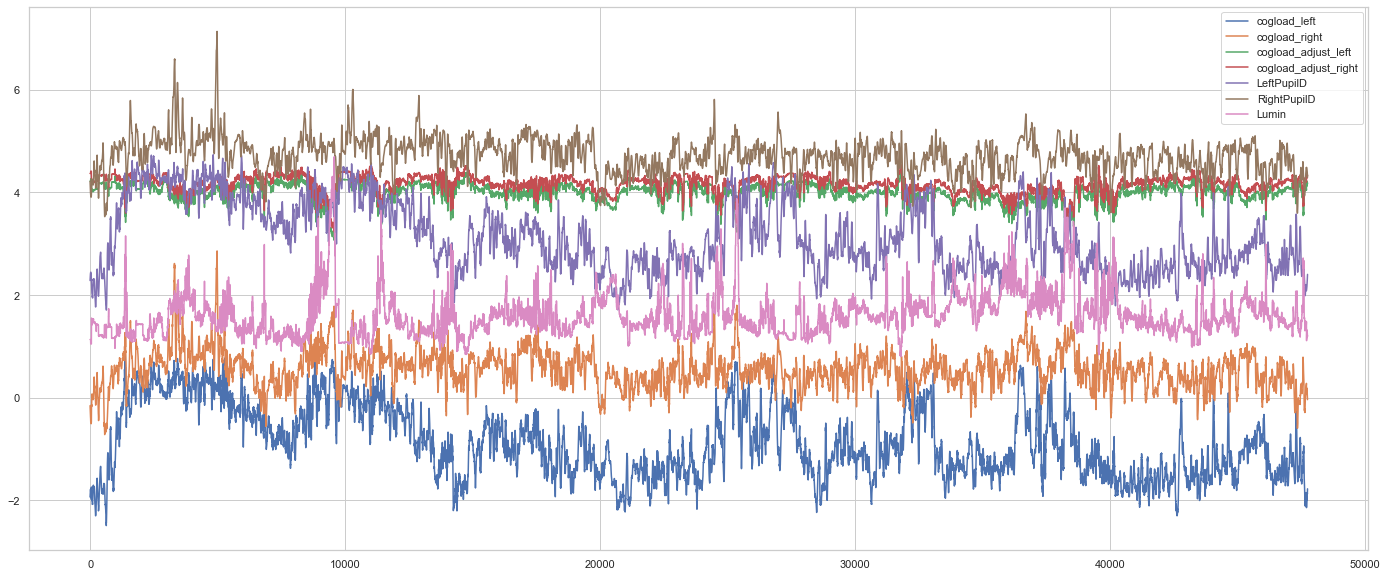

In [16]:
n = 19
plt.figure(figsize=(24,10))
plt.plot(data_raw[n]["cogload_left"],label='cogload_left')
plt.plot(data_raw[n]["cogload_right"],label='cogload_right')
plt.plot(data_raw[n]["cogload_adjust_left"],label='cogload_adjust_left')
plt.plot(data_raw[n]["cogload_adjust_right"],label='cogload_adjust_right')
plt.plot(data_raw[n]["LeftPupilD"],label='LeftPupilD')
plt.plot(data_raw[n]["RightPupilD"],label='RightPupilD')
plt.plot(data_raw[n]["Lumin"]*50,label='Lumin')
# plt.plot(data_raw[n]["cogload_left_baseline"],label='cogload_left_baseline')
# plt.plot(data_raw[n]["cogload_right_baseline"],label='cogload_right_baseline')
# plt.plot(data_raw[n]["cogload_left_percentage"],label='cogload_left_percentage')
# plt.plot(data_raw[n]["cogload_right_percentage"],label='cogload_right_percentage')
plt.legend()
plt.show()

In [ ]:
test_normality(data_raw)

In [17]:
### test ###
data_analysis

,condition,participant_id,label,mission_completed,time_all,time_1,time_2,time_3,time_4,cogload_average,damage_find,cogload_left,cogload_right,cogload_left_baseline,cogload_right_baseline,cogload_left_percentage,cogload_right_percentage,cogload_average_baseline,cogload_average_percentage
0,auto,01,0,4.0,351.033333,91.088889,63.933333,45.655556,150.322222,0.467989,2.0,-0.203256,-0.166220,0.809483,0.864391,0.246599,0.254112,0.836937,0.250355
1,cont,01,0,3.0,388.066667,100.300000,55.288889,52.444444,0.000000,0.326695,3.0,-0.347037,-0.350637,0.963503,0.800323,0.303104,0.228059,0.881913,0.265581
2,self,01,0,2.0,512.033333,58.633333,273.355556,0.000000,0.000000,0.557348,2.0,-0.113816,-0.101555,0.380105,0.483911,0.105917,0.132701,0.432008,0.119309
3,auto,02,0,3.0,393.055556,74.944444,219.844444,98.244444,0.000000,0.921321,3.0,0.546065,0.447355,0.844258,0.725197,0.208779,0.172173,0.784727,0.190476
4,cont,02,0,4.0,264.000000,53.800000,55.811111,30.122222,124.233333,0.971973,3.0,0.615004,0.630314,0.801574,0.831044,0.175982,0.185682,0.816309,0.180832
5,self,02,0,4.0,257.888889,46.477778,73.677778,25.122222,112.577778,1.048194,3.0,0.615510,0.741090,0.646612,0.757622,0.147437,0.173490,0.702117,0.160464
6,auto,03,0,4.0,277.788889,32.677778,114.666667,37.344444,93.066667,0.493762,3.0,0.047086,0.184127,0.843026,0.717887,0.246200,0.186725,0.780457,0.216462
7,cont,03,0,4.0,273.977778,40.555556,93.811111,25.222222,114.366667,0.611289,4.0,0.174881,0.294358,0.513731,0.539765,0.128668,0.126922,0.526748,0.127795
8,self,03,0,3.0,466.022222,46.422222,92.111111,327.455556,0.000000,1.003965,3.0,0.572407,0.670221,0.587941,0.680643,0.154951,0.165018,0.634292,0.159985
9,auto,04,0,3.0,407.055556,46.533333,294.177778,66.311111,0.000000,-0.257643,4.0,-0.724151,-0.692900,0.666480,0.703987,0.234175,0.234154,0.685234,0.234164


In [41]:
data_pairwise = data_analysis.drop([27,31,32])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
auto v.s. cont: Wilcoxon test (paired samples), P_val=3.927e-01 stat=6.500e+01
Using zero_method  pratt
cont v.s. self: Wilcoxon test (paired samples), P_val=2.685e-02 stat=3.500e+01
Using zero_method  pratt
auto v.s. self: Wilcoxon test (paired samples), P_val=1.203e-02 stat=2.900e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
auto v.s. cont: Wilcoxon test (paired samples), P_val=3.036e-02 stat=3.600e+01
Using zero_method  pratt
cont v.s. self: Wilcoxon test (paired samples), P_val=4.005e-03 stat=2.200e+01
Using zero_method  pratt
auto v.s. self: Wilcoxon test (paired samples), P_val=1.297e-01 stat=5.000e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1

[Text(0.5, 42.25, 'Wilcoxon analysis between groups'),
 Text(1707.1521739130435, 0.5, 'cogload_right_percentage')]

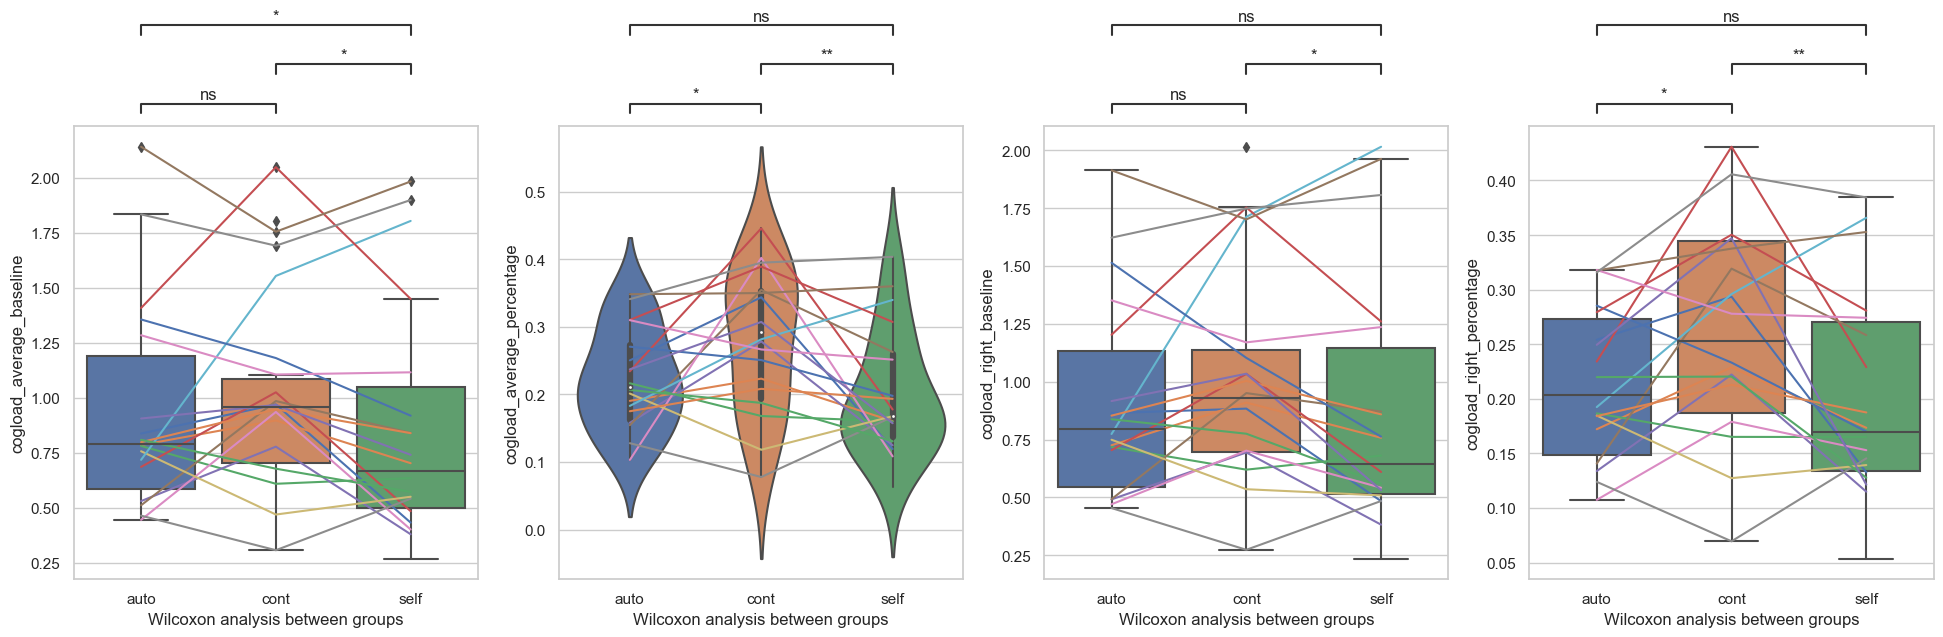

In [48]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
order = ["auto", "cont","self"]
method = 'Wilcoxon'
# method = 'Kruskal'
data = data_pairwise

fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)

# y = 'cogload_left_baseline'
y = 'cogload_average_baseline'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
for i in range(0,len(data_pairwise),3):
   axes[0].plot([data_analysis[[y]].values.ravel()[i],data_analysis[[y]].values.ravel()[i+1],data_analysis[[y]].values.ravel()[i+2]])
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

# y = "cogload_left_percentage"
y = "cogload_average_percentage"
axes[1] = sns.violinplot(ax = axes[1],data=data, x=x, y=y,order=order,)
for i in range(0,len(data_pairwise),3):
   axes[1].plot([data_analysis[[y]].values.ravel()[i],data_analysis[[y]].values.ravel()[i+1],data_analysis[[y]].values.ravel()[i+2]])
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "cogload_right_baseline"
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order,)
for i in range(0,len(data_pairwise),3):
   axes[2].plot([data_analysis[[y]].values.ravel()[i],data_analysis[[y]].values.ravel()[i+1],data_analysis[[y]].values.ravel()[i+2]])
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "cogload_right_percentage"
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order,)
for i in range(0,len(data_pairwise),3):
   axes[3].plot([data_analysis[[y]].values.ravel()[i],data_analysis[[y]].values.ravel()[i+1],data_analysis[[y]].values.ravel()[i+2]])
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

In [ ]:
### sample from raw data 
rate = 20
data_image = copy.deepcopy(data_auto[1])
subset = data_image[::rate]
## 3D Stastic ###
if 1:
    df = subset
    fig = px.scatter_3d(df, x='CameraPosX', y='CameraPosY', z='CameraPosZ',
                color='Trend_Sum',color_continuous_scale=px.colors.sequential.Viridis,symbol='light_state',symbol_sequence=["cross","circle"],opacity=0.8,)
    fig.update_traces(marker_size = 3)
    fig.show()

In [ ]:
############# total point data ###################

In [ ]:
auto_df = pd.DataFrame()
control_df = pd.DataFrame()
self_df = pd.DataFrame()

for i in range(len(data_auto)):
   auto_df = auto_df.append(pd.DataFrame(data_auto[i]["Trend_Sum"].values,columns=["Trend_Sum"]))
for i in range(len(data_control)):
   control_df = control_df.append(pd.DataFrame(data_control[i]["Trend_Sum"].values,columns=["Trend_Sum"]))
for i in range(len(data_self)):
   self_df = self_df.append(pd.DataFrame(data_self[i]["Trend_Sum"].values,columns=["Trend_Sum"]))
   
auto_df["Groups"] = "auto"
control_df["Groups"] = "control"
self_df["Groups"] = "self"
combine_df = pd.concat([auto_df,control_df,self_df])

combine_df.columns = ["CogLoad","Groups"]

In [ ]:
data = combine_df
x = 'Groups'
y = 'CogLoad'
order = ["auto", "control","self"]

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1,1, figsize=(5,3), dpi=100)

axes = sns.boxplot(ax = axes, data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes, data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                    (order[0], order[1]),
                                    (order[0], order[2]),
                                    (order[1], order[2]),
                                    ],
                                 test='Kruskal', 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=2,
                                 )

axes.set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')

In [ ]:
# TEST UI CHANGE #
i = 4
data_light = copy.deepcopy(data_auto[i])
data_light["state_change"] = data_light["light_state"].diff()
column_changes = data_light[data_light['state_change'] != 0]
UI_dark_list = column_changes["light_state"][column_changes["light_state"]==False].index
UI_light_list = column_changes["light_state"][column_changes["light_state"]==True].index
window = 10*90
cog_before = []
cog_after = []
for i in range(len(UI_dark_list)):
    cog_before.append(np.average(data_light["Trend_Sum"][UI_dark_list[i]-window:UI_dark_list[i]]))
    cog_after.append(np.average(data_light["Trend_Sum"][UI_dark_list[i]:UI_dark_list[i]+window]))
print(cog_before)
print(cog_after)

In [ ]:
i = 2
plt.plot(data_light["Trend_Sum"][UI_dark_list[i]-window:UI_dark_list[i]+window])
plt.axvline(x=UI_dark_list[i],c="r")
plt.show()

In [ ]:
plt.figure(figsize=(24,6))
plt.plot(data_light["Trend_Sum"])
for j in range(len(UI_dark_list)):
    plt.axvline(x=UI_dark_list[j],c="r")
    plt.axvline(x=UI_light_list[j],c="g")
plt.xlim((0,len(data_light["Trend_Sum"])))
plt.show()

In [ ]:
### dark ###
before_df = pd.DataFrame()
after_df = pd.DataFrame()
participant_number = 7
average = 1

# for i in range(len(data_auto)):
for i in range(participant_number,participant_number+1):
   before_data = pd.DataFrame()
   after_data = pd.DataFrame()
   
   data_light = copy.deepcopy(data_auto[i])
   data_light["state_change"] = data_light["light_state"].diff()
   column_changes = data_light[data_light['state_change'] != 0]
   UI_dark_list = column_changes["light_state"][column_changes["light_state"]==False].index
   window = 10*90
   for j in range(len(UI_dark_list)):
      before_data = before_data.append(pd.DataFrame(data_auto[i]["Trend_Sum"][UI_dark_list[j]-window:UI_dark_list[j]].values,columns=["Trend_Sum"]))
      after_data = after_data.append(pd.DataFrame(data_auto[i]["Trend_Sum"][UI_dark_list[j]:UI_dark_list[j]+window].values,columns=["Trend_Sum"]))
 
      if len(before_data) != 0:
         before_df = before_df.append(pd.DataFrame(before_data[["Trend_Sum"]].mean(axis=0).values,columns=["Trend_Sum"]))
         after_df = after_df.append(pd.DataFrame(after_data[["Trend_Sum"]].mean(axis=0).values,columns=["Trend_Sum"]))
      elif len(before_data) == 0:
         before_df = before_df.append(pd.DataFrame([np.nan],columns=["Trend_Sum"]))
         after_df = after_df.append(pd.DataFrame([np.nan],columns=["Trend_Sum"]))

group_1 = "Before_UI_dark"
group_2 = "After_UI_dark"

if average:
   before_df["Groups"] = group_1
   after_df["Groups"] = group_2
   combine_df = pd.concat([before_df,after_df])
else:
   before_data["Groups"] = group_1
   after_data["Groups"] = group_2
   combine_df = pd.concat([before_data,after_data])

combine_df.columns = ["CogLoad","Groups"]

In [ ]:
data = combine_df
x = 'Groups'
y = 'CogLoad'
hue = 'Groups'
order = [group_1, group_2]

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1,1, figsize=(5,3), dpi=100)

axes = sns.boxplot(ax = axes, data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes, data=data, x=x, y=y, order=order,
                                 box_pairs=[(order[0], order[1])],
                                 test='Kruskal', 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=2,
                                 )

axes.set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')

In [ ]:
### light ###
before_df = pd.DataFrame()
after_df = pd.DataFrame()
participant_number = 7
average = 1

# for i in range(len(data_auto)):
for i in range(participant_number,participant_number+1):
   before_data = pd.DataFrame()
   after_data = pd.DataFrame()
   
   data_light = copy.deepcopy(data_auto[i])
   data_light["state_change"] = data_light["light_state"].diff()
   column_changes = data_light[data_light['state_change'] != 0]
   UI_dark_list = column_changes["light_state"][column_changes["light_state"]==True].index
   window = 10*90
   for j in range(1,len(UI_dark_list)):
      before_data = before_data.append(pd.DataFrame(data_auto[i]["Trend_Sum"][UI_dark_list[j]-window:UI_dark_list[j]].values,columns=["Trend_Sum"]))
      after_data = after_data.append(pd.DataFrame(data_auto[i]["Trend_Sum"][UI_dark_list[j]:UI_dark_list[j]+window].values,columns=["Trend_Sum"]))
 
      if len(before_data) != 0:
         before_df = before_df.append(pd.DataFrame(before_data[["Trend_Sum"]].mean(axis=0).values,columns=["Trend_Sum"]))
         after_df = after_df.append(pd.DataFrame(after_data[["Trend_Sum"]].mean(axis=0).values,columns=["Trend_Sum"]))
      elif len(before_data) == 0:
         before_df = before_df.append(pd.DataFrame([np.nan],columns=["Trend_Sum"]))
         after_df = after_df.append(pd.DataFrame([np.nan],columns=["Trend_Sum"]))

group_1 = "Before_UI_light"
group_2 = "After_UI_light"

before_df["Groups"] = group_1
after_df["Groups"] = group_2

combine_df = pd.concat([before_df,after_df])
combine_df.columns = ["CogLoad","Groups"]

In [ ]:
data = combine_df
x = 'Groups'
y = 'CogLoad'
hue = 'Groups'
order = [group_1, group_2]

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1,1, figsize=(5,3), dpi=100)

if 1:
   axes = sns.boxplot(ax = axes, data=data, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes, data=data, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1])],
                                    test='Kruskal', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=2,
                                    )

   axes.set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')


In [ ]:
data_analysis_lightstate = pd.DataFrame()
for i in range(len(data_auto)):
   light_group = data_auto[i].groupby(["light_state"]).get_group(1)
   condition = "light"
   cogload_average = (np.average(light_group["Trend_Sum"]))
   damage_find = float(len(light_group.damageTargetName.unique()) - 1)
   data_analysis_lightstate = data_analysis_lightstate.append(pd.DataFrame([[condition,cogload_average,damage_find]],
                                          columns=["condition","cogload_average","damage_find"]),
                                          ignore_index=True)   
   
   condition = "dark"
   if len(data_auto[i].light_state.unique()) == 1:
      cogload_average = np.nan
      damage_find = np.nan      
   elif len(data_auto[i].light_state.unique()) == 2:
      dark_group = data_auto[i].groupby(["light_state"]).get_group(0)
      cogload_average = (np.average(dark_group["Trend_Sum"]))
      damage_find = float(len(dark_group.damageTargetName.unique()) - 1)
   
   data_analysis_lightstate = data_analysis_lightstate.append(pd.DataFrame([[condition,cogload_average,damage_find]],
                                          columns=["condition","cogload_average","damage_find"]),
                                          ignore_index=True)

In [ ]:
data = data_analysis_lightstate
x = 'condition'
order = ["light", "dark"]
sns.set(style = 'whitegrid')

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)
y = 'cogload_average'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "damage_find"
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)


In [ ]:
################################################# segment participant ########################################################################

In [ ]:
label_small_group = data_analysis.groupby(["label"]).get_group(0)
label_large_group = data_analysis.groupby(["label"]).get_group(1)

In [ ]:
### pair analysis visualization 
data = label_small_group
sns.set(style = 'whitegrid')
x = 'condition'
order = ["auto", "cont","self"]
method = 'Kruskal'

fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)

y = 'cogload_average'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "damage_find"
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "time_all"
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

In [ ]:
################################# self ####################################

In [ ]:
self_data_analysis = pd.DataFrame()
labels = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
UI_state = pd.DataFrame()
for i in range(len(data_self)):
    time_all = len(data_self[i])
    participant_id = data_self[i][["participant_id"]][0:1].values.ravel()[0]
    label = labels[int(participant_id)-1]

    MissionP_group = data_self[i].groupby(["MissionP"])
    MissionP_light = len(MissionP_group.get_group(1))
    if len(MissionP_group) == 2:
        MissionP_dark = len(MissionP_group.get_group(0))
    elif len(MissionP_group) == 1:
        MissionP_dark = np.nan
    MissionP_change_df = pd.DataFrame()
    MissionP_change_df["change"] = data_self[i]["MissionP"].diff()
    MissionP_change_df = MissionP_change_df.dropna()
    MissionP_change = len(MissionP_change_df[MissionP_change_df["change"]] != 0)
    MissionP_percentage = MissionP_light/time_all


    TaskP_group = data_self[i].groupby(["TaskP"])
    TaskP_light = len(TaskP_group.get_group(1))
    if len(TaskP_group) == 2:
        TaskP_dark = len(TaskP_group.get_group(0))
    elif len(TaskP_group) == 1:
        TaskP_dark = np.nan
    TaskP_change = len(TaskP_group[["TaskP"]].diff())
    TaskP_change_df = pd.DataFrame()
    TaskP_change_df["change"] = data_self[i]["TaskP"].diff()
    TaskP_change_df = TaskP_change_df.dropna()
    TaskP_change = len(TaskP_change_df[TaskP_change_df["change"]] != 0)
    TaskP_percentage = TaskP_light/time_all


    IconsP_group = data_self[i].groupby(["IconsP"])
    IconsP_light = len(IconsP_group.get_group(1))
    if len(IconsP_group) == 2:
        IconsP_dark = len(IconsP_group.get_group(0))
    elif len(IconsP_group) == 1:
        IconsP_dark = np.nan
    IconsP_change = len(IconsP_group[["IconsP"]].diff())
    IconsP_change_df = pd.DataFrame()
    IconsP_change_df["change"] = data_self[i]["IconsP"].diff()
    IconsP_change_df = IconsP_change_df.dropna()
    IconsP_change = len(IconsP_change_df[IconsP_change_df["change"]] != 0)
    IconsP_percentage = IconsP_light/time_all


    TimerP_group = data_self[i].groupby(["TimerP"])
    TimerP_light = len(TimerP_group.get_group(1))
    if len(TimerP_group) == 2:
        TimerP_dark = len(TimerP_group.get_group(0))
    elif len(TimerP_group) == 1:
        TimerP_dark = np.nan
    TimerP_change = len(TimerP_group[["TimerP"]].diff())
    TimerP_change_df = pd.DataFrame()
    TimerP_change_df["change"] = data_self[i]["TimerP"].diff()
    TimerP_change_df = TimerP_change_df.dropna()
    TimerP_change = len(TimerP_change_df[TimerP_change_df["change"]] != 0)
    TimerP_percentage = TimerP_light/time_all


    self_data_analysis = self_data_analysis.append(pd.DataFrame([[participant_id,label,time_all,MissionP_light,MissionP_dark,MissionP_change,MissionP_percentage,
                                                        TaskP_light,TaskP_dark,TaskP_change,TaskP_percentage,
                                                        IconsP_light,IconsP_dark,IconsP_change,IconsP_percentage,
                                                        TimerP_light,TimerP_dark,TimerP_change,TimerP_percentage]],
                                            columns=["participant_id","label","time_all","MissionP_light","MissionP_dark","MissionP_change","MissionP_percentage",
                                                    "TaskP_light","TaskP_dark","TaskP_change","TaskP_percentage",
                                                    "IconsP_light","IconsP_dark","IconsP_change","IconsP_percentage",
                                                    "TimerP_light","TimerP_dark","TimerP_change","TimerP_percentage"]),
                                            ignore_index=True)

In [ ]:
self_data_analysis

In [ ]:
######################## Trajectory and entropy #################################

In [16]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        
        return sum(C)

    N = len(U)
    if _phi(m) == 0:
        return 0.2
    else:
        return -np.log(_phi(m + 1) / _phi(m))


In [17]:
column_names = ['CameraPos','EyePos']
axis3 = ['X','Y','Z']
local_name = locals()

for data_list in (data_auto,data_control,data_self):
    for j in range(len(data_list)):
        t = data_list[j]
        for axis in axis3:
            for column_name in column_names:
                local_name[column_name + '_vel_' + axis] = []
                local_name[column_name + '_acc_' + axis] = []
                local_name[column_name + '_p_' + axis + '_previous'] = 0
                local_name[column_name + '_vel_' + axis + '_previous'] = 0
                
                
                for i,local_name[column_name + '_p_' + axis] in t[column_name + axis].iteritems():
                    ## get vel by delta_p
                    local_name[column_name + '_delta_p_' + axis] = abs(local_name[column_name + '_p_' + axis] - local_name[column_name + '_p_' + axis + '_previous'])
                    if local_name[column_name + '_delta_p_' + axis]>100.0:
                        local_name[column_name + '_vel_' + axis].append(0)
                    else:
                        local_name[column_name + '_vel_' + axis].append(local_name[column_name + '_delta_p_' + axis])
                    local_name[column_name + '_p_' + axis + '_previous'] = local_name[column_name + '_p_' + axis]

                    ## get acc by delta_vel
                    local_name[column_name + '_delta_vel_' + axis] = abs(local_name[column_name + '_delta_p_' + axis] - local_name[column_name + '_vel_' + axis + '_previous'])
                    if local_name[column_name + '_delta_vel_' + axis]>100.0:
                        local_name[column_name + '_acc_' + axis].append(0)
                    else:
                        local_name[column_name + '_acc_' + axis].append(local_name[column_name + '_delta_vel_' + axis])
                    local_name[column_name + '_vel_' + axis + '_previous'] = local_name[column_name + '_delta_p_' + axis]

                t[column_name + '_vel_' + axis] = local_name[column_name + '_vel_' + axis]
                t[column_name + '_acc_' + axis] = local_name[column_name + '_acc_' + axis]


In [13]:
data_auto[0]

,FrameID,EyePosX,EyePosY,EyePosZ,GazePosX,GazePosY,GazePosZ,GazePointRotX,GazePointRotY,GazePointRotZ,...,EyePos_vel_X,EyePos_acc_X,CameraPos_vel_Y,CameraPos_acc_Y,EyePos_vel_Y,EyePos_acc_Y,CameraPos_vel_Z,CameraPos_acc_Z,EyePos_vel_Z,EyePos_acc_Z
0,90,22.76953,4.833004,7.440859,23.75048,4.966516,7.662416,359.1976,261.9356,0.000000e+00,...,22.76953,22.76953,4.988140,4.988140,4.833004,4.833004,7.462737,7.462737,7.440859,7.440859
1,91,22.76940,4.833050,7.440867,23.75048,4.966514,7.662417,359.1422,262.0532,-8.005024e-08,...,0.00013,22.76940,0.000003,4.988137,0.000046,4.832958,0.000002,7.462735,0.000008,7.440851
2,92,22.76882,4.837038,7.444274,23.75047,4.965272,7.659433,359.1422,262.0532,-5.336683e-08,...,0.00058,0.00045,0.000104,0.000101,0.003988,0.003942,0.000134,0.000132,0.003407,0.003399
3,93,22.76866,4.833001,7.444939,23.75046,4.964165,7.657113,359.0968,262.1639,0.000000e+00,...,0.00016,0.00042,0.000119,0.000015,0.004037,0.000049,0.000102,0.000032,0.000665,0.002742
4,94,22.76898,4.831234,7.442869,23.75045,4.962871,7.654799,359.0572,262.2499,0.000000e+00,...,0.00032,0.00016,0.000071,0.000048,0.001767,0.002270,0.000075,0.000027,0.002070,0.001405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31538,31628,22.05177,4.682032,12.078020,19.99847,3.762825,13.286490,336.7817,121.5608,-9.290150e-07,...,0.00749,1.66560,0.000155,0.000155,0.000392,1.318931,0.010380,0.010380,0.012220,1.213930
31539,31629,22.03909,4.668590,12.088030,19.99847,3.762825,13.286490,336.6359,121.7286,0.000000e+00,...,0.01268,0.00519,0.000000,0.000155,0.013442,0.013050,0.000000,0.010380,0.010010,0.002210
31540,31630,22.05342,4.670639,12.113640,19.99516,3.762867,13.297980,336.6359,121.7286,0.000000e+00,...,0.01433,0.00165,0.000077,0.000077,0.002049,0.011393,0.007100,0.007100,0.025610,0.015600
31541,31631,22.04547,4.660729,12.121720,19.99516,3.762867,13.297980,336.5827,121.9266,0.000000e+00,...,0.00795,0.00638,0.000000,0.000077,0.009910,0.007861,0.000000,0.007100,0.008080,0.017530


In [18]:
column_names = ['CameraPos','EyePos']
axis3 = ['X','Y','Z']
local_name = locals()
for data_list in (data_auto,data_control,data_self):
    for i in range(len(data_list)):
        t = data_list[i]
        condition = data_list[i][["condition"]][0:1].values.ravel()[0]
        participant_id = data_list[i][["participant_id"]][0:1].values.ravel()[0]
        for column_name in column_names:
            r_set = 0.2 * np.std(data_auto[0][column_name + "_vel_X"].values)
            for axis in axis3:
                local_name[participant_id  + '_' + condition + '_' + column_name + '_vel_' + axis + '_entropy'] = []            
                        
                # vel = t['vel_' + axis][t['vel_' + axis]!=0].values
                vel = t[[column_name + '_vel_' + axis]].groupby(np.arange(len(t[[column_name + '_vel_' + axis]]))//10).mean()
                local_name[participant_id  + '_' + condition + '_' + column_name + '_vel_' + axis + '_entropy'].append(SampEn(vel.values, m=2, r=r_set))
                
                np.save(path + participant_id  + '_' + condition + '_' + column_name + '_vel_' + axis + '_entropy',local_name[participant_id  + '_' + condition + '_' + column_name + '_vel_' + axis + '_entropy'])
                # t['vel_' + axis + '_entropy'] = local_name['vel_' + axis + '_entropy']
                # print([participant_id  + '_' + condition + '_' + column_name + '_vel_' + axis + '_entropy'])

In [10]:
path = '../../data/result/divide 10 entropy/'
column_names = ['CameraPos','EyePos']
local_name = locals()

names =['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',]
axis3 = ['X','Y','Z']
groups = ['cont','auto','self']
# point_states = ['before','after']
total_df = pd.DataFrame()

for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for column_name in column_names:
            local_name[name  + '_' + group + '_' + column_name + '_df'] = pd.DataFrame()
            for axis in axis3:
                if os.path.exists(path + name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy.npy'):
                    local_name[name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy.npy')
                else:
                    local_name[name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy'] = [np.nan]
                local_name[name  + '_' + group + '_' + column_name + '_df']['entropy' + '_vel_' + axis] = local_name[name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy']
                local_name[name + '_dict'][name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_' + column_name + '_vel_' + axis + '_entropy']
            local_name[name  + '_' + group + '_' + column_name + '_df']['column_name'] = column_name
            local_name[name  + '_' + group + '_df'] = local_name[name  + '_' + group + '_df'].append(local_name[name  + '_' + group + '_' + column_name + '_df'])
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df']['participant_id'] = name
    # local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    # entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_combine.csv")  

In [ ]:
total_df.groupby(['column_name']).get_group('CameraPos')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

cont v.s. auto: Kruskal-Wallis paired samples, P_val=9.534e-01 stat=3.419e-03
auto v.s. self: Kruskal-Wallis paired samples, P_val=8.553e-01 stat=3.324e-02
cont v.s. self: Kruskal-Wallis paired samples, P_val=7.360e-01 stat=1.137e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

cont v.s. auto: Kruskal-Wallis paired samples, P_val=5.786e-01 stat=3.085e-01
auto v.s. self: Kruskal-Wallis paired samples, P_val=9.033e-01 stat=1.477e-02
cont v.s. self: Kruskal-Wallis paired samples, P_val=8.661e-01 stat=2.842e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

cont v.s. auto: Kruskal-Wallis paired sa

[Text(0.5, 42.25, 'Kruskal analysis between groups'),
 Text(1161.2058823529412, 0.5, 'entropy_vel_Z')]

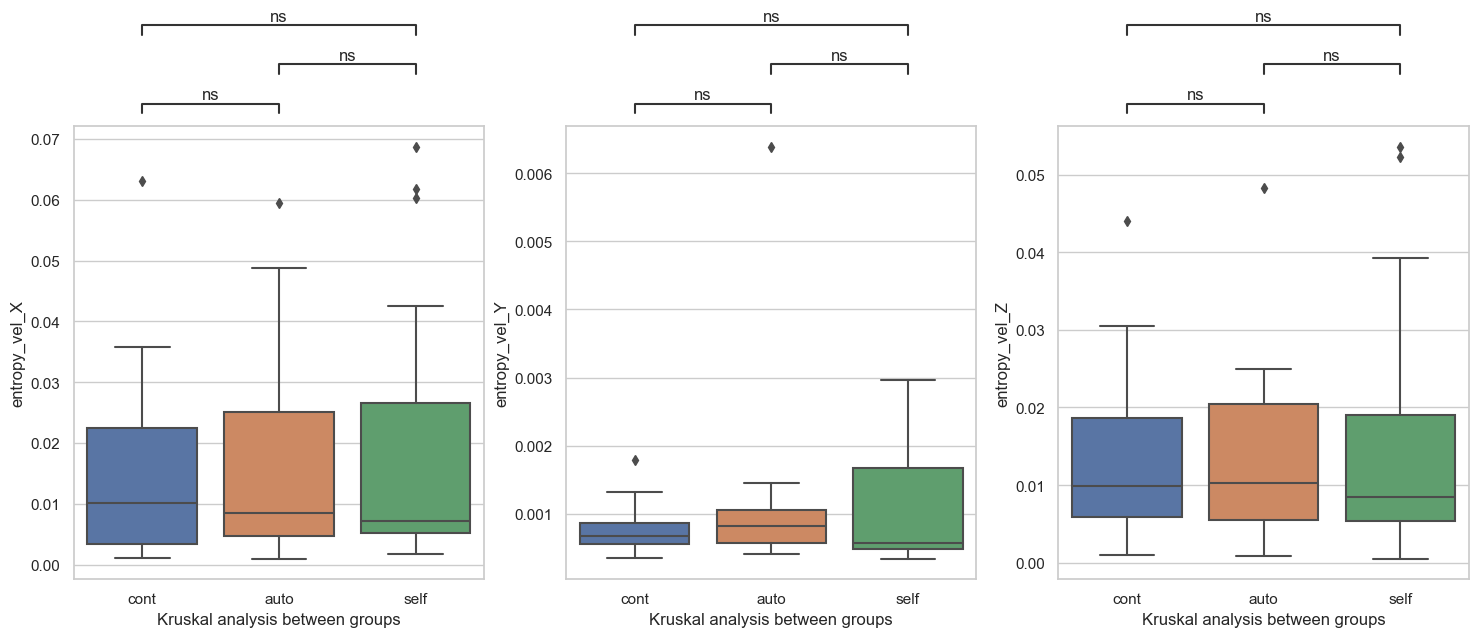

In [17]:
data_camera = total_df.groupby(['column_name']).get_group('CameraPos')
data_eye = total_df.groupby(['column_name']).get_group('EyePos')
data = data_camera
x = 'Groups'
order = ["cont", "auto","self"]
sns.set(style = 'whitegrid')

fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)
method = "Kruskal"

y = 'entropy_vel_X'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "entropy_vel_Y"
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "entropy_vel_Z"
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired samples, P_val=6.823e-01 stat=1.675e-01
cont v.s. self: Kruskal-Wallis paired samples, P_val=2.325e-04 stat=1.355e+01
auto v.s. self: Kruskal-Wallis paired samples, P_val=1.277e-03 stat=1.037e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired samples, P_val=5.587e-01 stat=3.419e-01
cont v.s. self: Kruskal-Wallis paired samples, P_val=1.056e-02 stat=6.538e+00
auto v.s. self: Kruskal-Wallis paired samples, P_val=4.825e-02 stat=3.901e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired sa

[Text(0.5, 17.25, 'Kruskal analysis between groups'),
 Text(1406.0434782608697, 0.5, 'EyePos_Y_vel_mean')]

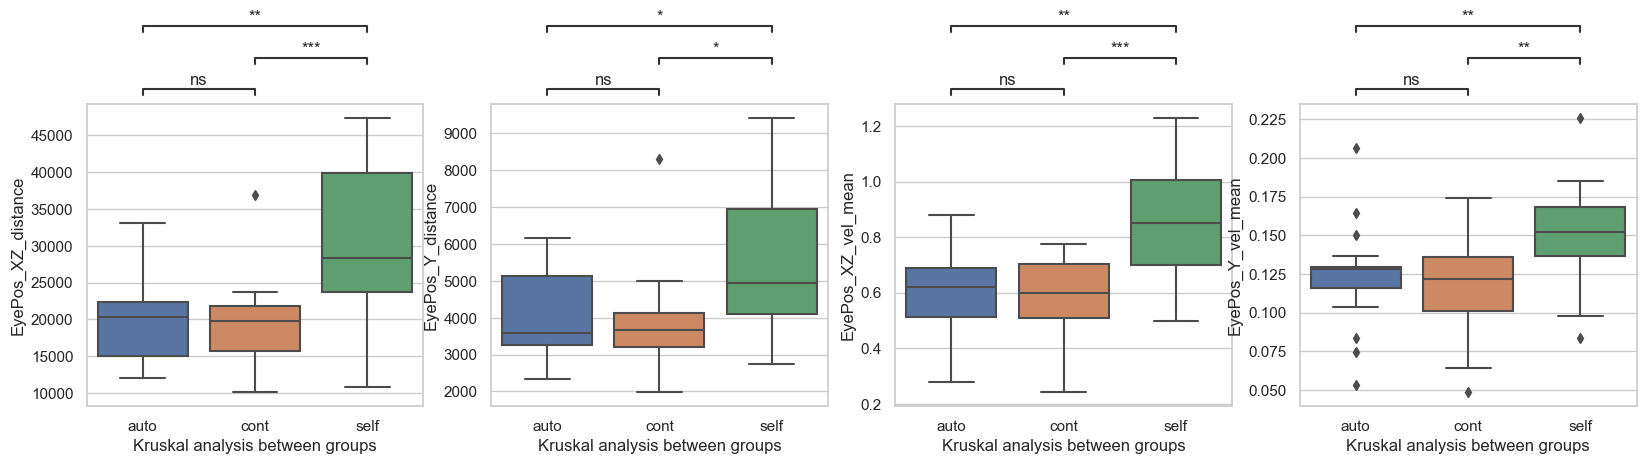

In [19]:
auto_df = pd.DataFrame()
control_df = pd.DataFrame()
self_df = pd.DataFrame()
column_names = ['CameraPos','EyePos']
column_name = column_names[1]

for i in range(len(data_auto)):
   auto_df = auto_df.append(pd.DataFrame([data_auto[i][column_name + "_vel_X"].sum() + data_auto[i][column_name + "_vel_Z"].sum()],columns=[column_name + "_XZ_distance"]))
   auto_df = auto_df.append(pd.DataFrame([data_auto[i][column_name + "_vel_Y"].sum()],columns=[column_name + "_Y_distance"]))
   auto_df = auto_df.append(pd.DataFrame([data_auto[i][column_name + "_vel_X"].mean() + data_auto[i][column_name + "_vel_Z"].mean()],columns=[column_name + "_XZ_vel_mean"]))
   auto_df = auto_df.append(pd.DataFrame([data_auto[i][column_name + "_vel_Y"].mean()],columns=[column_name + "_Y_vel_mean"]))
   auto_df["Groups"] = "auto"
for i in range(len(data_control)):
   control_df = control_df.append(pd.DataFrame([data_control[i][column_name + "_vel_X"].sum() + data_control[i][column_name + "_vel_Z"].sum()],columns=[column_name + "_XZ_distance"]))
   control_df = control_df.append(pd.DataFrame([data_control[i][column_name + "_vel_Y"].sum()],columns=[column_name + "_Y_distance"]))
   control_df = control_df.append(pd.DataFrame([data_control[i][column_name + "_vel_X"].mean() + data_control[i][column_name + "_vel_Z"].mean()],columns=[column_name + "_XZ_vel_mean"]))
   control_df = control_df.append(pd.DataFrame([data_control[i][column_name + "_vel_Y"].mean()],columns=[column_name + "_Y_vel_mean"]))
   control_df["Groups"] = "cont"
for i in range(len(data_self)):
   self_df = self_df.append(pd.DataFrame([data_self[i][column_name + "_vel_X"].sum() + data_self[i][column_name + "_vel_Z"].sum()],columns=[column_name + "_XZ_distance"]))
   self_df = self_df.append(pd.DataFrame([data_self[i][column_name + "_vel_Y"].sum()],columns=[column_name + "_Y_distance"]))
   self_df = self_df.append(pd.DataFrame([data_self[i][column_name + "_vel_X"].mean() + data_self[i][column_name + "_vel_Z"].mean()],columns=[column_name + "_XZ_vel_mean"]))
   self_df = self_df.append(pd.DataFrame([data_self[i][column_name + "_vel_Y"].mean()],columns=[column_name + "_Y_vel_mean"]))
   self_df["Groups"] = "self"
   
combine_df = pd.concat([auto_df,control_df,self_df])

fig, axes = plt.subplots(1,4, figsize=(20,4), dpi=100)
data = combine_df
x = 'Groups'
sns.set(style = 'whitegrid')
order = ["auto", "cont","self"]
method = 'Kruskal'

y = column_name + '_XZ_distance'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = column_name + "_Y_distance"
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = column_name + "_XZ_vel_mean"
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

y = column_name + "_Y_vel_mean"
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[3].set(xlabel = method + ' analysis between groups', ylabel=y)

In [ ]:
######################### k-means clustering ##################################

In [ ]:
participant_group = data_analysis.groupby(["participant_id"])

In [ ]:
average_participant_cogload = []
for h,d in participant_group:
    average_participant_cogload.append(np.mean(d[["cogload_average"]].values))

In [ ]:
## gap statistic ## 
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
import numpy as np
EuclDist = scipy.spatial.distance.euclidean
def gapStat(data, resf=None, nrefs=50, ks=range(1,20)):
    '''
    Gap statistics
    '''
    # MC
    shape = data.shape
    if resf == None:
        x_max = data.max(axis=0)
        x_min = data.min(axis=0)
        dists = np.matrix(np.diag(x_max-x_min))
        rands = np.random.random_sample(size=(shape[0], shape[1], nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+x_min
    else:
        rands = refs
    s1 = np.zeros((len(ks),))
    s2 = np.zeros((len(ks),))
    gaps = np.zeros((len(ks),))
    gapDiff = np.zeros(len(ks)-1,)
    sdk = np.zeros(len(ks),)
    for (i,k) in enumerate(ks):
        (cluster_mean, cluster_res) = scipy.cluster.vq.kmeans2(data, k)
        Wk = sum([EuclDist(data[m,:], cluster_mean[cluster_res[m],:]) for m in range(shape[0])])
        WkRef = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            WkRef[j] = sum([EuclDist(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        s1[i] = scipy.log(Wk)
        s2[i] = scipy.log(scipy.mean(WkRef))
        gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
        sdk[i] = np.sqrt((1.0+nrefs)/nrefs)*np.std(scipy.log(WkRef))

        if i > 0:
            gapDiff[i-1] = gaps[i-1] - gaps[i] + sdk[i]
    return gaps, gapDiff, s2, s1

In [ ]:
gaps,gapsDiff, s2, s1 = gapStat(np.array(average_participant_cogload).reshape(-1, 1))
X = range(1,20)
f, (a1,a2,a3) = plt.subplots(3,1,figsize=(8,8))
a1.plot(X,s1,'o-')
a1.plot(X,s2,'o-')
a2.plot(X,gaps, 'g-o')
a3.bar(np.arange(1,19),gapsDiff)
f.show()

In [ ]:
## Silhouette Coefficient ##
Scores = []
for i in range(2,15):
    estimator = KMeans(i)
    estimator.fit(np.array(average_participant_cogload).reshape(-1, 1))
    Scores.append(silhouette_score(np.array(average_participant_cogload).reshape(-1, 1),estimator.labels_,metric='euclidean'))
X = range(2,15)
plt.plot(X,Scores,'o-')

In [ ]:
n_clus = 2
kmeans_clustering = KMeans(n_clusters=n_clus, random_state=0).fit(np.array(average_participant_cogload).reshape(-1,1))
labels = kmeans_clustering.labels_
# joblib.dump(sax_kmeans_left, path + 'sax_kmeans_left.pkl')
# test_model = joblib.load(path + 'sax_kmeans.pkl') 
print(labels)


In [ ]:
cluster_df = pd.DataFrame()
for i in range(len(average_participant_cogload)):
    participant_id = i+1
    average_load = average_participant_cogload[i]
    participant_label = labels[i]
    cluster_df = cluster_df.append(pd.DataFrame([[participant_id,average_load,participant_label]],
                                                columns=["participant_id","average_load","participant_label"]),
                                                ignore_index=True)

In [ ]:
cluster_df